The motivation for this notebook is to check whether the exact constraints of mass & enthalpy conservation always hold in every dataset that we would like to study, notably the base (fluxbypassaqua), and the two generalization datasets (+4K) and (+3Kw1). We will:  
1) Check the water budget in dimensional and dimensionless forms in the base dataset  
2) Move to (+4K) to see if it still holds

# 1) Load constants, network configuration, etc

In [161]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# 2) +0K Validation dataset

In [162]:
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/'
import xarray as xr
import numpy as np
ds = xr.open_dataset(DATADIR + 'AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-02-02-00000.nc', 
                     decode_times=False)
ds0 = xr.open_dataset(DATADIR + 'AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-02-01-00000.nc', 
                     decode_times=False)

In [163]:
ds.VD01

<xarray.DataArray 'VD01' (time: 48, lev: 30, lat: 64, lon: 128)>
[11796480 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) float64 32.0 32.02 32.04 32.06 ... 32.92 32.94 32.96 32.98
Attributes:
    units:        kg/kg/s
    long_name:    Vertical diffusion of Q
    cell_method:  time: mean

## Local conservation

In [164]:
# Pick a point
it = 5
ilon = 23
ilat = 35
# Calculate residual
# 0) Pressure coordinate
P = np.expand_dims(ds.P0,axis=0)*hyai+\
np.expand_dims(ds.PS[it,ilon,ilat],axis=0)*hybi;
dP = P[1:]-P[:-1]
# 1) Water integral
WATINT = np.sum(L_V/G*dP*\
                (ds.PHCLDICE[it,:,ilon,ilat]+\
                 ds.PHCLDLIQ[it,:,ilon,ilat]+\
                 ds.PHQ[it,:,ilon,ilat]),axis=0);
# 2) Precipitation
PREC = RHO_L*L_V*(ds.PRECT[it,ilon,ilat]+\
                  1e-3*ds.PRECTEND[it,ilon,ilat]);
# 3) Latent heat flux
LHF = ds.LHFLX[it-1,ilon,ilat];
# 3) Residual of water budget
RES = -WATINT-PREC+LHF;
print('WATINT',WATINT.values)
print('PREC',PREC.values)
print('LHF',LHF.values)
print('RES',RES.values)

WATINT 79.41151849249485
PREC 0.3312984943448783
LHF 79.7429
RES 8.00468516786168e-05


In [165]:
RES

<xarray.DataArray ()>
array(8.004685e-05)
Coordinates:
    lat      float64 -23.72
    lon      float64 98.44

## Global conservation

In [166]:
# 0) Pressure coordinate
P = np.moveaxis(np.tile(np.expand_dims(ds.P0,axis=0)*hyai,\
                        (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
                3,1)+\
np.moveaxis(np.tile(ds.PS[1:,:,:],(hybi.shape[0],1,1,1)),0,1)*\
np.moveaxis(np.tile(hybi,\
                    (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
            3,1)
dP = P[:,1:,:,:]-P[:,:-1,:,:]
# 1) Water integral
WATINT = np.sum(L_V/G*dP*(ds.PHCLDICE[1:,:,:,:]+\
                          ds.PHCLDLIQ[1:,:,:,:]+\
                          ds.PHQ[1:,:,:,:]),axis=1);
# 2) Precipitation
PREC = RHO_L*L_V*(ds.PRECT[1:,:,:]+1e-3*ds.PRECTEND[1:,:,:]);
# 3) Residual of water budget
RES = -WATINT-PREC+ds.LHFLX.values[:-1,:,:]; 

WATINT -4.8313900769658815
PREC 82.226135
LHF 77.39475
RESIDUAL -2.921435914140063e-07


(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.85988e+05,
        1.99034e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

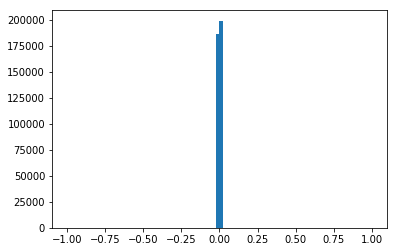

In [167]:
print('WATINT',WATINT.values.mean(axis=(0,1,2)))
print('PREC',PREC.values.mean(axis=(0,1,2)))
print('LHF',ds.LHFLX.values[:-1,:,:].mean(axis=(0,1,2)))
print('RESIDUAL',RES.values.mean(axis=(0,1,2)))
plt.hist(RES.values.flatten(), bins=100, range=(-1,1))

# 3) +4K dataset

In [168]:
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/'
import xarray as xr
import numpy as np
ds = xr.open_dataset(DATADIR + 'sp8fbp_4k.cam2.h2.0000-01-01-00000.nc', 
                     decode_times=False)
ds0 = xr.open_dataset(DATADIR + 'sp8fbp_4k.cam2.h2.0000-02-03-00000.nc', 
                     decode_times=False)

In [169]:
# 0) Pressure coordinate
P = np.moveaxis(np.tile(np.expand_dims(ds.P0,axis=0)*hyai,\
                        (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
                3,1)+\
np.moveaxis(np.tile(ds.PS[1:,:,:],(hybi.shape[0],1,1,1)),0,1)*\
np.moveaxis(np.tile(hybi,\
                    (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
            3,1)
dP = P[:,1:,:,:]-P[:,:-1,:,:]
# 1) Water integral
WATINT = np.sum(L_V/G*dP*(ds.PHCLDICE[1:,:,:,:]+\
                          ds.PHCLDLIQ[1:,:,:,:]+\
                          ds.PHQ[1:,:,:,:]),axis=1);
# 2) Precipitation
PREC = RHO_L*L_V*(ds.PRECT[1:,:,:]+1e-3*ds.PRECTEND[1:,:,:]);
# 3) Residual of water budget
RES = -WATINT-PREC+ds.LHFLX.values[:-1,:,:]; 

WATINT 48.110187875568684
PREC 112.25614
LHF 160.53363
RESIDUAL 0.16731585527022774


(array([545., 572., 605., 607., 574., 600., 626., 563., 603., 678., 646.,
        608., 691., 607., 633., 668., 630., 628., 684., 699., 731., 728.,
        720., 699., 725., 748., 701., 714., 738., 762., 740., 787., 763.,
        826., 827., 778., 822., 816., 868., 843., 810., 859., 832., 864.,
        816., 884., 859., 957., 931., 913., 959., 914., 972., 917., 962.,
        985., 973., 943., 931., 954., 908., 891., 935., 948., 884., 916.,
        890., 970., 908., 903., 938., 894., 878., 856., 873., 902., 863.,
        833., 926., 855., 877., 861., 824., 821., 798., 820., 801., 792.,
        848., 796., 833., 809., 785., 740., 763., 769., 763., 738., 764.,
        793.]),
 array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
        -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
        -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 , -0.48,
        -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 ,
        -0.28, -0.26, -0.24, -0.22

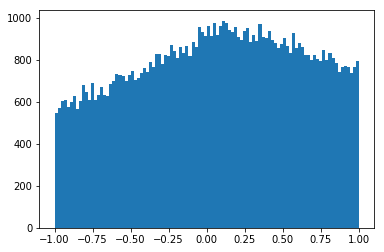

In [170]:
print('WATINT',WATINT.values.mean(axis=(0,1,2)))
print('PREC',PREC.values.mean(axis=(0,1,2)))
print('LHF',ds.LHFLX.values[:-1,:,:].mean(axis=(0,1,2)))
print('RESIDUAL',RES.values.mean(axis=(0,1,2)))
plt.hist(RES.values.flatten(), bins=100, range=(-1,1))

# 4) +3Kw1 dataset

In [171]:
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_3kw1/'
import xarray as xr
import numpy as np
ds = xr.open_dataset(DATADIR + 'sp8fbp_3kw1.cam2.h2.0001-04-03-00000.nc', 
                     decode_times=False)
ds0 = xr.open_dataset(DATADIR + 'sp8fbp_3kw1.cam2.h2.0001-04-02-00000.nc', 
                     decode_times=False)

In [172]:
# 0) Pressure coordinate
P = np.moveaxis(np.tile(np.expand_dims(ds.P0,axis=0)*hyai,\
                        (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
                3,1)+\
np.moveaxis(np.tile(ds.PS[1:,:,:],(hybi.shape[0],1,1,1)),0,1)*\
np.moveaxis(np.tile(hybi,\
                    (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
            3,1)
dP = P[:,1:,:,:]-P[:,:-1,:,:]
# 1) Water integral
WATINT = np.sum(L_V/G*dP*(ds.PHCLDICE[1:,:,:,:]+\
                          ds.PHCLDLIQ[1:,:,:,:]+\
                          ds.PHQ[1:,:,:,:]),axis=1);
# 2) Precipitation
PREC = RHO_L*L_V*(ds.PRECT[1:,:,:]+1e-3*ds.PRECTEND[1:,:,:]);
# 3) Residual of water budget
RES = -WATINT-PREC+ds.LHFLX.values[:-1,:,:]; 

WATINT -1.055444878138102
PREC 74.544716
LHF 73.510574
RESIDUAL 0.021287452722341758


(array([ 943.,  946., 1010., 1029., 1083., 1013., 1055., 1047., 1069.,
        1068., 1206., 1201., 1202., 1232., 1205., 1228., 1295., 1296.,
        1350., 1397., 1474., 1494., 1564., 1567., 1555., 1590., 1611.,
        1667., 1810., 1796., 1855., 1969., 1915., 2036., 1951., 2054.,
        2074., 2218., 2292., 2324., 2409., 2367., 2435., 2577., 2621.,
        2598., 2706., 2726., 2892., 2991., 3035., 2952., 2892., 2774.,
        2647., 2760., 2723., 2683., 2504., 2559., 2404., 2348., 2342.,
        2228., 2261., 2124., 2128., 2049., 1954., 1973., 1868., 1844.,
        1841., 1845., 1727., 1726., 1666., 1656., 1546., 1540., 1547.,
        1405., 1461., 1454., 1309., 1345., 1284., 1287., 1267., 1224.,
        1157., 1194., 1165., 1133., 1136., 1050., 1066., 1001.,  980.,
        1030.]),
 array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
        -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
        -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.

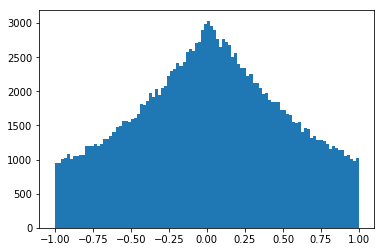

In [173]:
print('WATINT',WATINT.values.mean(axis=(0,1,2)))
print('PREC',PREC.values.mean(axis=(0,1,2)))
print('LHF',ds.LHFLX.values[:-1,:,:].mean(axis=(0,1,2)))
print('RESIDUAL',RES.values.mean(axis=(0,1,2)))
plt.hist(RES.values.flatten(), bins=100, range=(-1,1))